---
permalink: /vae/
layout: single
author_profile: true
title: Variational AutoEncoders (VAE) with PyTorch
folder: "vae"
ipynb: "vae.ipynb"
md: "vae.md"
excerpt: Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an **encoder** $e$ and a **decoder** $d$.
header:
  teaser: /assets/vae/variational-autoencoder.png
---

# Motivation

Imagine that we have a large, high-dimensional dataset. For example, imagine we have a dataset consisting of thousands of images. Each image  is made up of hundreds of pixels, so each data point has hundreds of dimensions. The **[manifold hypothesis](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis)** states that real-world high-dimensional data actually consists of low-dimensional data that is embedded in the high-dimensional space. This means that, while the actual data itself might have hundreds of dimensions, the underlying structure of the data can be sufficiently described using only a few dimensions.

This is the motivation behind dimensionality reduction techniques, which try to take high-dimensional data and project it onto a lower-dimensional surface. For humans who visualize most things in 2D (or sometimes 3D), this usually means projecting the data onto a 2D surface. Examples of dimensionality reduction techniques include [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Chris Olah's blog has a [great post](https://colah.github.io/posts/2014-10-Visualizing-MNIST/) reviewing some dimensionality reduction techniques applied to the MNIST dataset.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

![variational autoencoder](variational-autoencoder.png)

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions (the full expression for two arbitrary univariate Gaussians is derived in [this math.stackexchange post](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)). Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [2]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, latent_dims)
        self.linear3 = nn.Linear(256, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [3]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [4]:
def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(np.squeeze(sample), cmap='gray')
    ax[index].axis('off')

def train(autoencoder, train_loader, vali_loader, epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters(),lr=0.001)
    loss_list=[]
    fig, ax = plt.subplots(nrows=6, ncols=15)
    images, number = next(iter(vali_loader))
    ax[0, 0].set_title('Original digits')
    plot_samples(ax[0,0:], images)
    plot_num = 1
    for epoch in range(epochs):
        loss_sum=0
        total=0
        for x, y in train_loader:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss_sum += loss.item()
            total += y.size(0)
            loss.backward()
            opt.step()
        print('Epoch', epoch, 'loss', loss_sum/total)
        loss_list.append(loss_sum/total)
        
        if epoch in [0,4,24,49,99]:
            recon = autoencoder(images).detach().numpy()
            ax[plot_num, 0].set_title('Epoch {}'.format(epoch))
            plot_samples(ax[plot_num, 0:], recon)
            plot_num += 1
    plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')
    return autoencoder, loss_list

Epoch 0 loss 54.69089587402344
Epoch 1 loss 44.79896056111654
Epoch 2 loss 43.1677367960612
Epoch 3 loss 42.37051073201497
Epoch 4 loss 41.84367034912109
Epoch 5 loss 41.46942553710937
Epoch 6 loss 41.16441735839844
Epoch 7 loss 40.92080741373698
Epoch 8 loss 40.6914680480957
Epoch 9 loss 40.513425364176435
Epoch 10 loss 40.33812963867187
Epoch 11 loss 40.19578045654297
Epoch 12 loss 40.00637530517578
Epoch 13 loss 39.87326225789388
Epoch 14 loss 39.76280795288086
Epoch 15 loss 39.63228212483724
Epoch 16 loss 39.53094499715169
Epoch 17 loss 39.43698911539713
Epoch 18 loss 39.329350524902345
Epoch 19 loss 39.25268493652344
Epoch 20 loss 39.149229288736976
Epoch 21 loss 39.097067077636716
Epoch 22 loss 39.00658037312826
Epoch 23 loss 38.9212229309082
Epoch 24 loss 38.86024868774414
Epoch 25 loss 38.82032033284505
Epoch 26 loss 38.74057774861654
Epoch 27 loss 38.69359188842773
Epoch 28 loss 38.63624272664388
Epoch 29 loss 38.58330553181966
Epoch 30 loss 38.551266794840494
Epoch 31 loss 38

Text(0, 0.5, 'Loss')

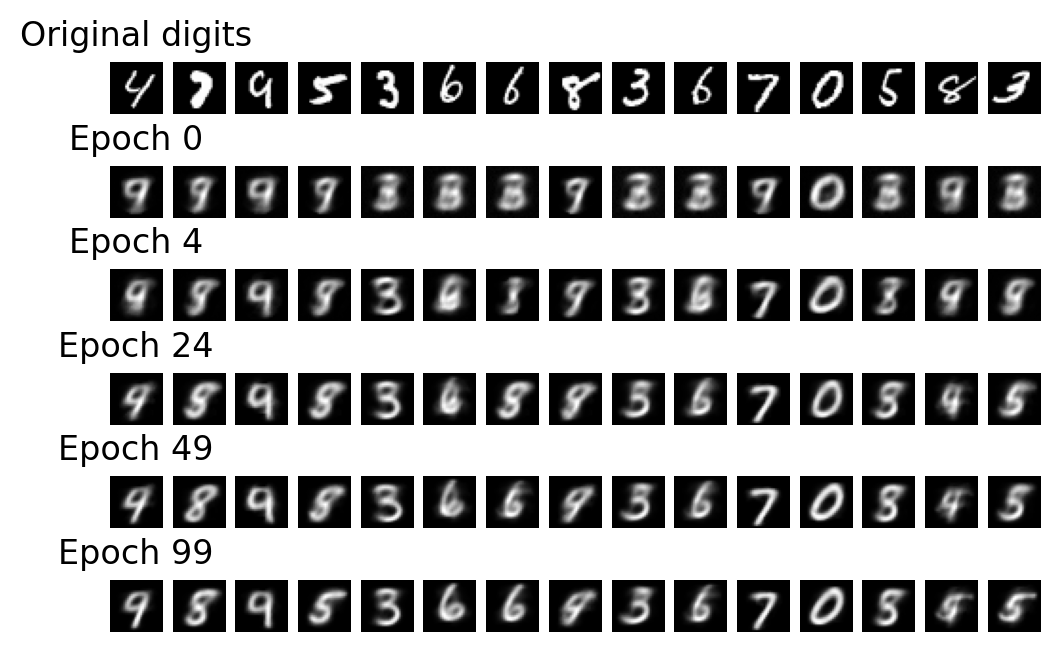

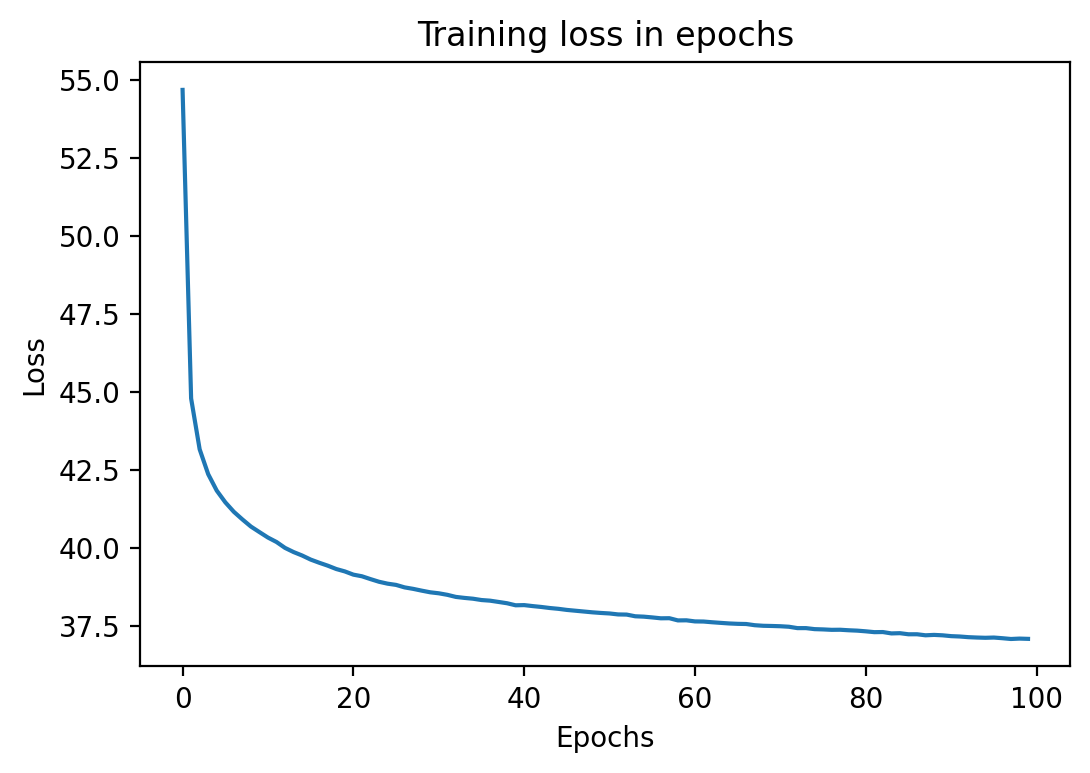

In [5]:
latent_dims = 2
dataset = torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128, shuffle=True)
vali_loader = torch.utils.data.DataLoader(val_set, batch_size=15, shuffle=False)
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae, loss_list = train(vae, train_loader, vali_loader)

plt.figure(2)
plt.plot(loss_list)
plt.title('Training loss in epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Let's plot the latent vector representations of a few batches of data.

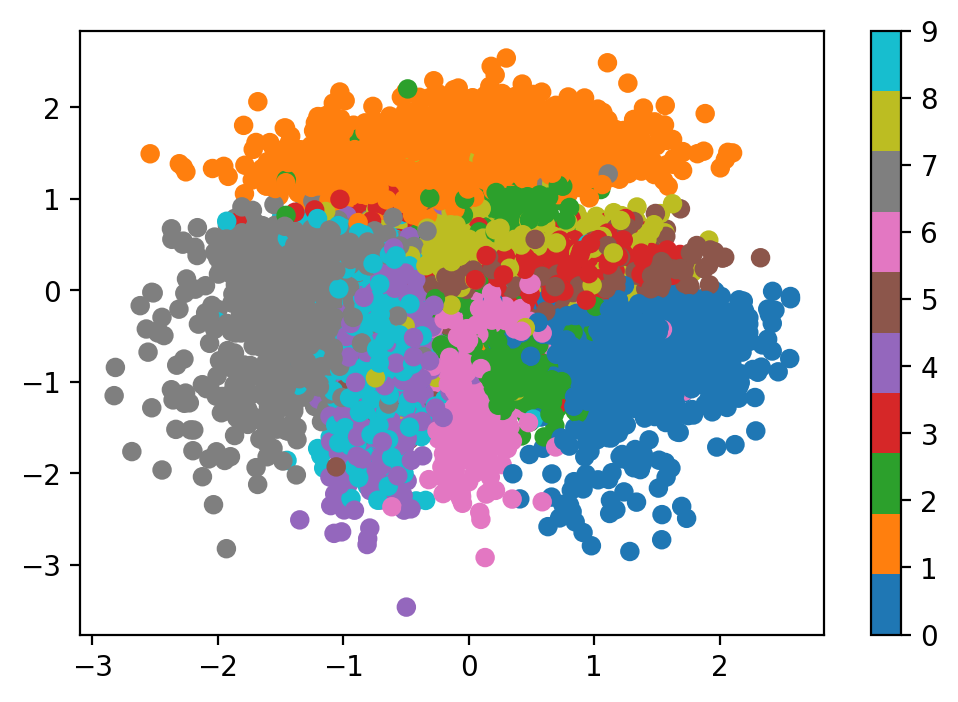

In [6]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(vae, train_loader)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

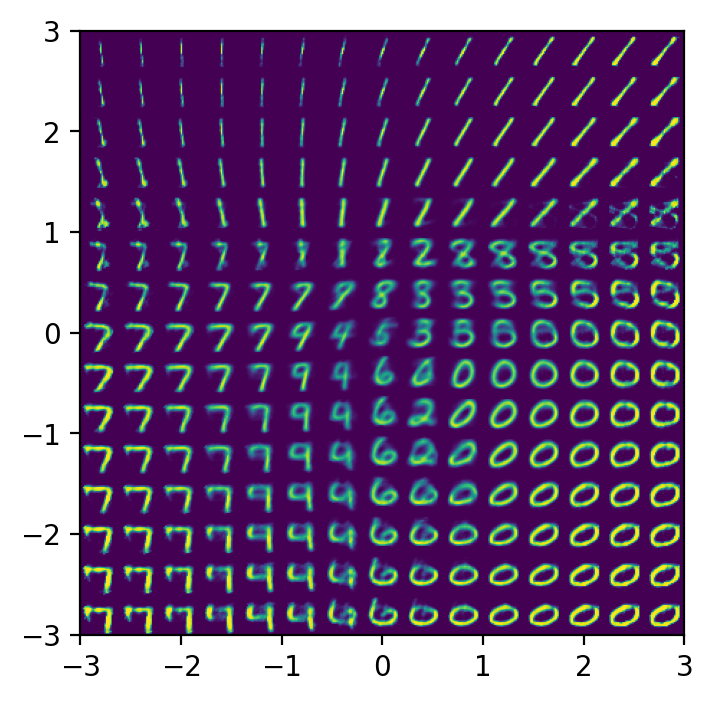

In [7]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

# Extra Fun

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [8]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [10]:
x, y = train_loader.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

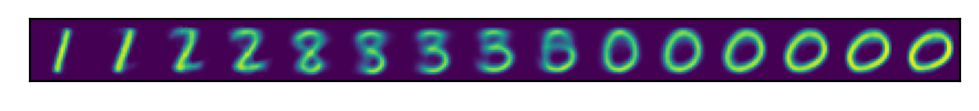

In [11]:
interpolate(vae, x_1, x_2, n=15)

Epoch 0 loss 64.40935290527344
Epoch 1 loss 50.441125091552735
Epoch 2 loss 47.325876088460284
Epoch 3 loss 45.6905349222819
Epoch 4 loss 44.69572119140625
Epoch 5 loss 43.99150735473633
Epoch 6 loss 43.498369618733726
Epoch 7 loss 43.14715347290039
Epoch 8 loss 42.86166013590495
Epoch 9 loss 42.61820617675781
Epoch 10 loss 42.413757232666015
Epoch 11 loss 42.282375295003256
Epoch 12 loss 42.14361233520508
Epoch 13 loss 42.01345470174154
Epoch 14 loss 41.90574247233073
Epoch 15 loss 41.801609639485676
Epoch 16 loss 41.73057941691081
Epoch 17 loss 41.60824100748698
Epoch 18 loss 41.5782280476888
Epoch 19 loss 41.51166367594401
Epoch 20 loss 41.41670721435547
Epoch 21 loss 41.38279697672526
Epoch 22 loss 41.339856221516925
Epoch 23 loss 41.27743634033203
Epoch 24 loss 41.199483489990236
Epoch 25 loss 41.17845544433594
Epoch 26 loss 41.14862180582682
Epoch 27 loss 41.092981180826825
Epoch 28 loss 41.065858662923176
Epoch 29 loss 41.05039889526367
Epoch 30 loss 40.98115540568034
Epoch 31 l

Text(0, 0.5, 'Loss')

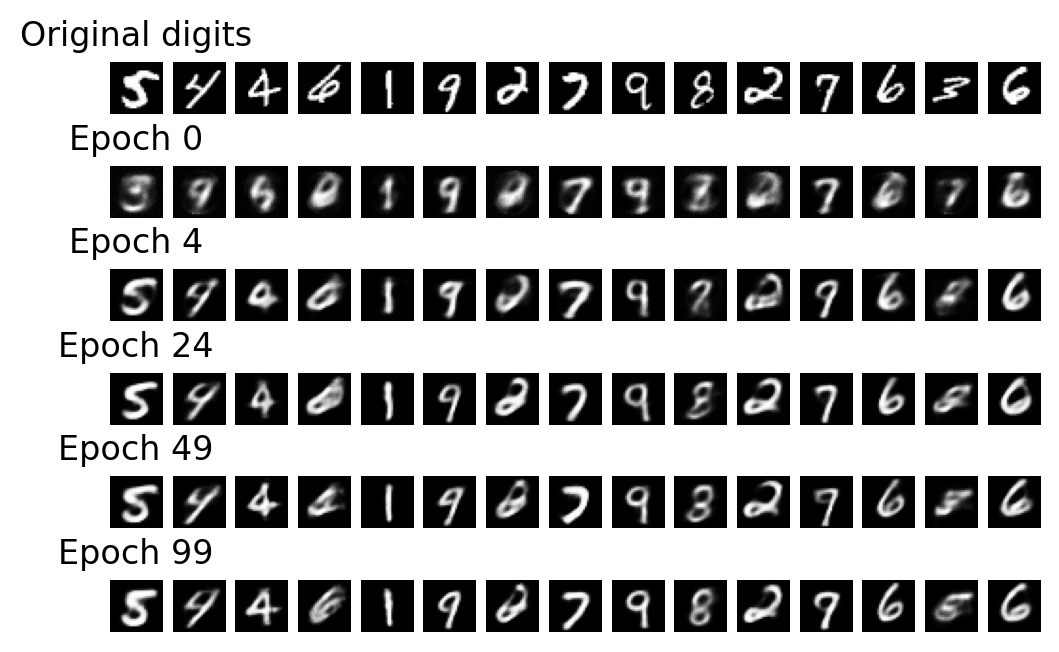

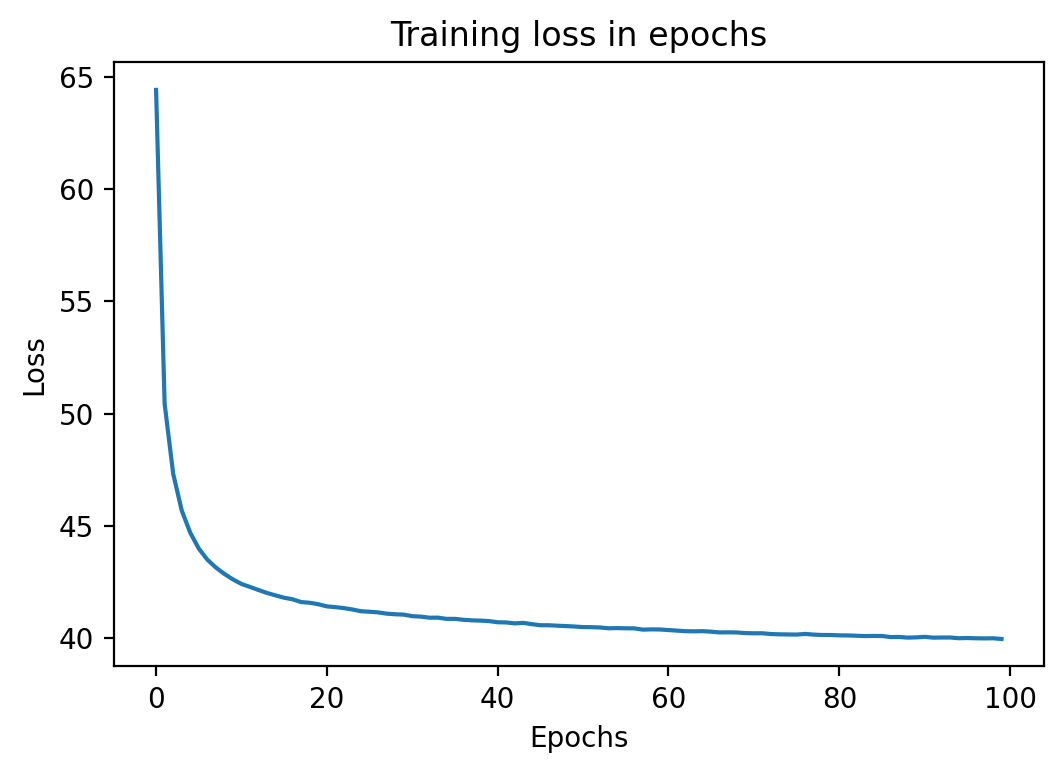

In [12]:
latent_dims = 32
dataset = torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128, shuffle=True)
vali_loader = torch.utils.data.DataLoader(val_set, batch_size=15, shuffle=False)
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae, loss_list = train(vae, train_loader, vali_loader)

plt.figure(2)
plt.plot(loss_list)
plt.title('Training loss in epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

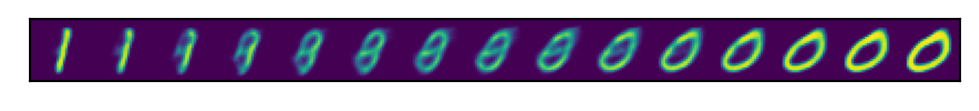

In [14]:
x, y = train_loader.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0
interpolate(vae, x_1, x_2, n=15)

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)